# 초기 세팅

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [57]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [58]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [59]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

# FashionMNIST 분류 모델 만들기
* 흑/백(1) 이미지 데이터 분류
* 28x28 pixel

## 데이터 로드

In [60]:
# 데이터 전처리

MNIST_transform = transforms.Compose([transforms.ToTensor(), # tensor로 펴준다.
                                      transforms.Normalize((0.5,),(0.5,))]) # 정규화를 해준다.

In [61]:
trainset = datasets.FashionMNIST(root='/content',
                                 train=True, download=True,
                                 transform=MNIST_transform)

testset = datasets.FashionMNIST(root='/content',
                                 train=False, download=True,
                                 transform=MNIST_transform)

input-data size 확인

In [62]:
# batch-size=128
train_loader128 =  DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader128 =  DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# batch-size=64
train_loader64 =  DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader64 =  DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

In [63]:
# 128 : batch-size
# 1 : 흑백
# 28x28 : pixel-size

images128, labels128 = next(iter(train_loader128))
images128.shape, labels128.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [64]:
# 64 : batch-size
# 1 : 흑백
# 28x28 : pixel-size

images64, labels64 = next(iter(train_loader64))
images64.shape, labels64.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [65]:
# 숫자 label에 해당되는 값

labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot'
}

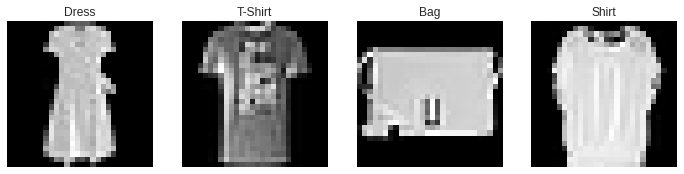

In [66]:
# 데이터 확인

figure = plt.figure(figsize=(12,12))
cols, rows = 4, 1

for i in range(1, cols * rows + 1):
    image = images128[i].squeeze()
    label_idx = labels128[i].item() # y_label
    label = labels_map[label_idx] # 위에서 해당되는 label

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

plt.show()

## 모델 1 생성
* 10개의 convolution-layer(Conv2d)와 2개의 fully-connected(fc)로 이루어진 모델
* Total params: 28,784

input-data size
* train_loader128(batch-size;128) : 128, 1, 28, 28
* train_loader64(batch-size;64) : 64, 1, 28, 28


구현해야하는 모델 정보<br>
* convolution-layer 1
* maxpooling-layer
* convolution-layer 2
* convolution-layer 3
* convolution-layer 4
* convolution-layer 5
* convolution-layer 6
* convolution-layer 7
* convolution-layer 8
* convolution-layer 9
* maxpooling-layer
* convolution-layer 10
* flatten
* fc1
* fc2

추가 정보
* 활성화함수 : relu
(단, maxpooling과 마지막 fc2에는 보통적으로 활성화함수를 사용하지 않는다.)
* flatten의 경우, weights가 들어가지 않는다. 즉, layer라고는 볼 수 없다.

모델의 layer를 통과함에 따라 데이터의 크기 변화는 다음과 같다.
1. batch-size128 -> torch.Size([128, 1, 28, 28]) 으로 시작
2. batch-size;64 -> torch.Size([64, 1, 28, 28]) 으로 시작
> * torch.Size([128 or 64, 5, 30, 30])
> * torch.Size([128 or 64, 5, 15, 15])
> * torch.Size([128 or 64, 7, 15, 15])
> * torch.Size([128 or 64, 16, 16, 16])
> * torch.Size([128 or 64, 19, 15, 15])
> * torch.Size([128 or 64, 29, 13, 13])
> * torch.Size([128 or 64, 29, 14, 14])
> * torch.Size([128 or 64, 6, 12, 12])
> * torch.Size([128 or 64, 2, 12, 12])
> * torch.Size([128 or 64, 10, 7, 7])
> * torch.Size([128 or 64, 20, 7, 7])
> * torch.Size([128 or 64, 20, 3, 3])
> * torch.Size([128 or 64, 180])
> * torch.Size([128 or 64, 86])
> * torch.Size([128 or 64, 10]) 

In [67]:
class CNN_Model1(nn.Module):
    def __init__(self):
        super(CNN_Model1, self).__init__()



        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        # in-channels = 1 <- 흑/백
        # out-channels = 5
        # kernel_size / filter-size = 2x2 -> f=3
        # stride = 1(default) -> s=1
        # padding = 2(default) -> p=2
        # input-data pixel size = 28x28 -> n=28
        # (n-f+2p)/s + 1 = new n
        # (28-3+2x2)/1 + 1 = 30
    
        # maxpool : n=30 -> 15

        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        # in-channels = 5 <- 이전것의 out-channels
        # out-channels = 7
        # filter-size = 3x3
        # stride = 1(default)
        # padding = 1
        # (n-f+2p)/s + 1 = new n    
        # (15-3+2x1)/1 + 1 = 15

        self.conv3 = nn.Conv2d(in_channels=7, out_channels=16, kernel_size=4, stride=1, padding=2)
        # (15-4+2*2)/1 + 1 = 16
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=19, kernel_size=4, stride=1, padding=1)
        # (16-4+2*1)/1 + 1 = 15
        self.conv5 = nn.Conv2d(in_channels=19, out_channels=29, kernel_size=5, stride=1, padding=1)
        # (15-5+2*1)/1 +1 = 13
        self.conv6 = nn.Conv2d(in_channels=29, out_channels=29, kernel_size=2, stride=1, padding=1)
        # (13-2+2*1)/1 +1 = 14
        self.conv7 = nn.Conv2d(in_channels=29, out_channels=6, kernel_size=5, stride=1, padding=1)
        # (14-5+2*1)/1 +1 = 12
        self.conv8 = nn.Conv2d(in_channels=6, out_channels=2, kernel_size=3, stride=1, padding=1)
        # (12-3+2*1)/1 +1 = 12
        self.conv9 = nn.Conv2d(in_channels=2, out_channels=10, kernel_size=2, stride=2, padding=1)
        # (12-2+2*1)/2 +1 = 7
        # maxpool : n=7 -> 3
        self.conv10 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)
        # (3-3+2*1)/1 +1 = 3

        self.fc1 = nn.Linear(20 * 3 * 3, 86)
        self.fc2 = nn.Linear(86, 10)
        # 10 : 10개의 category

    def forward(self, x):
       x = F.relu(self.conv1(x))
       #print(x.size()) 
       x = F.max_pool2d(x, (2,2), stride=2)
       #print(x.size()) 
       x = F.relu(self.conv2(x))
       #print(x.size()) 
       x = F.relu(self.conv3(x))
       #print(x.size()) 
       x = F.relu(self.conv4(x))
       #print(x.size()) 
       x = F.relu(self.conv5(x))
       #print(x.size()) 
       x = F.relu(self.conv6(x))
       #print(x.size()) 
       x = F.relu(self.conv7(x))
       #print(x.size()) 
       x = F.relu(self.conv8(x))
       #print(x.size()) 
       x = F.relu(self.conv9(x))
       #print(x.size()) 
       x = F.max_pool2d(x, 2, stride=2)
       #print(x.size()) 
       x = F.relu(self.conv10(x))
       #print(x.size()) 
       x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의
       
       x = F.relu(self.fc1(x))
       #print(x.size())
       x = self.fc2(x)
       #print(x.size(), '\n\n')
       
       return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [68]:
# 모델객체 생성
DeepConv_net128 = CNN_Model1().to(device)
DeepConv_net64 = CNN_Model1().to(device)

print(DeepConv_net128)

CNN_Model1(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(16, 19, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(19, 29, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(29, 29, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(29, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(6, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(2, 10, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (conv10): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=180, out_features=86, bias=True)
  (fc2): Linear(in_features=86, out_features=10, bias=True)
)


In [69]:
input = images128.to(device)
input.size()

torch.Size([128, 1, 28, 28])

In [70]:
output = DeepConv_net128.forward(input)
output.size()

torch.Size([128, 10])

In [71]:
summary(DeepConv_net128, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]           1,808
            Conv2d-4          [128, 19, 15, 15]           4,883
            Conv2d-5          [128, 29, 13, 13]          13,804
            Conv2d-6          [128, 29, 14, 14]           3,393
            Conv2d-7           [128, 6, 12, 12]           4,356
            Conv2d-8           [128, 2, 12, 12]             110
            Conv2d-9            [128, 10, 7, 7]              90
           Conv2d-10            [128, 20, 3, 3]           1,820
           Linear-11                  [128, 86]          15,566
           Linear-12                  [128, 10]             870
Total params: 47,072
Trainable params: 47,072
Non-trainable params: 0
---------------------------------

In [72]:
input = images64.to(device)
input.size()

torch.Size([64, 1, 28, 28])

In [73]:
output = DeepConv_net64.forward(input)
output.size()

torch.Size([64, 10])

In [74]:
summary(DeepConv_net64, input_size=(1, 28, 28), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 5, 30, 30]              50
            Conv2d-2            [64, 7, 15, 15]             322
            Conv2d-3           [64, 16, 16, 16]           1,808
            Conv2d-4           [64, 19, 15, 15]           4,883
            Conv2d-5           [64, 29, 13, 13]          13,804
            Conv2d-6           [64, 29, 14, 14]           3,393
            Conv2d-7            [64, 6, 12, 12]           4,356
            Conv2d-8            [64, 2, 12, 12]             110
            Conv2d-9             [64, 10, 7, 7]              90
           Conv2d-10             [64, 20, 3, 3]           1,820
           Linear-11                   [64, 86]          15,566
           Linear-12                   [64, 10]             870
Total params: 47,072
Trainable params: 47,072
Non-trainable params: 0
---------------------------------

## 모델 2 생성
* 2개의 convolution-layer(Conv2d)와 5개의 fully-connected(fc)로 이루어진 모델
* Total params: 9,516,488

input-data size
* train_loader128(batch-size;128) : 128, 1, 28, 28
* train_loader64(batch-size;64) : 64, 1, 28, 28


구현해야하는 모델 정보<br>
* convolution-layer 1
* maxpooling-layer
* convolution-layer 2
* flatten
* fc1
* fc2
* fc3
* fc4
* fc5

추가 정보
* 활성화함수 : relu
(단, maxpooling과 마지막 fc5에는 보통적으로 활성화함수를 사용하지 않는다.)
* flatten의 경우, weights가 들어가지 않는다. 즉, layer라고는 볼 수 없다.

모델의 layer를 통과함에 따라 데이터의 크기 변화는 다음과 같다.

1. batch-size128 -> torch.Size([128, 1, 28, 28]) 으로 시작
2. batch-size;64 -> torch.Size([64, 1, 28, 28]) 으로 시작
> * torch.Size([128 or 64, 5, 30, 30])
> * torch.Size([128 or 64, 5, 15, 15])
> * torch.Size([128 or 64, 7, 15, 15])
> * torch.Size([128 or 64, 1575])
> * torch.Size([128 or 64, 3000])
> * torch.Size([128 or 64, 1500])
> * torch.Size([128 or 64, 180])
> * torch.Size([128 or 64, 86])
> * torch.Size([128 or 64, 10])

In [75]:
class CNN_Model2(nn.Module):
    def __init__(self):
        super(CNN_Model2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        self.fc1 = nn.Linear(7 * 15 * 15, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 180)
        self.fc4 = nn.Linear(180, 86)
        self.fc5 = nn.Linear(86, 10)

    def forward(self, x):
      x = F.relu(self.conv1(x)) 
      #print(x.size())
      x = F.max_pool2d(x,(2,2))
      #print(x.size())
      x = F.relu(self.conv2(x))
      #print(x.size())
      
      x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의
      #print(x.size())
      

      x = F.relu(self.fc1(x))
      #print(x.size())
      x = F.relu(self.fc2(x))
      #print(x.size())
      x = F.relu(self.fc3(x))
      #print(x.size())
      x = F.relu(self.fc4(x))
      #print(x.size())
      x = self.fc5(x)
      #print(x.size(), '\n\n')
      return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [76]:
# 모델객체 생성
DeepFC_net128 = CNN_Model2().to(device)
DeepFC_net64 = CNN_Model2().to(device)

print(DeepFC_net128)

CNN_Model2(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1575, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=86, bias=True)
  (fc5): Linear(in_features=86, out_features=10, bias=True)
)


In [77]:
input = images128.to(device)
input.size()

torch.Size([128, 1, 28, 28])

In [78]:
output = DeepFC_net128.forward(input)
output.size()

torch.Size([128, 10])

In [79]:
summary(DeepFC_net128, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Linear-3                [128, 3000]       4,728,000
            Linear-4                [128, 1500]       4,501,500
            Linear-5                 [128, 180]         270,180
            Linear-6                  [128, 86]          15,566
            Linear-7                  [128, 10]             870
Total params: 9,516,488
Trainable params: 9,516,488
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 10.60
Params size (MB): 36.30
Estimated Total Size (MB): 47.28
----------------------------------------------------------------


In [80]:
input = images64.to(device)
input.size()

torch.Size([64, 1, 28, 28])

In [81]:
output = DeepFC_net64.forward(input)
output.size()

torch.Size([64, 10])

In [82]:
summary(DeepFC_net64, input_size=(1, 28, 28), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 5, 30, 30]              50
            Conv2d-2            [64, 7, 15, 15]             322
            Linear-3                 [64, 3000]       4,728,000
            Linear-4                 [64, 1500]       4,501,500
            Linear-5                  [64, 180]         270,180
            Linear-6                   [64, 86]          15,566
            Linear-7                   [64, 10]             870
Total params: 9,516,488
Trainable params: 9,516,488
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 5.30
Params size (MB): 36.30
Estimated Total Size (MB): 41.79
----------------------------------------------------------------


## 손실함수와 옵티마이저

In [83]:
criterion = nn.CrossEntropyLoss()

optimizerDC_128 = optim.SGD(DeepConv_net128.parameters(), lr=0.001, momentum=0.9)
optimizerDC_64 = optim.SGD(DeepConv_net64.parameters(), lr=0.001, momentum=0.9)
optimizerFC_128 = optim.SGD(DeepFC_net128.parameters(), lr=0.001, momentum=0.9)
optimizerFC_64 = optim.SGD(DeepFC_net64.parameters(), lr=0.001, momentum=0.9)

## 모델 학습

### 1. DeepConv_net128
* 10개의 Convolution-layer & 2개의 fc-layer
* 128 batch-size

In [84]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11529107999801635
Epoch: 1, Iter: 200, Loss: 0.11523732531070709
Epoch: 1, Iter: 300, Loss: 0.11524857938289643
Epoch: 1, Iter: 400, Loss: 0.11516190338134766
Epoch: 2, Iter: 100, Loss: 0.11517930150032044
Epoch: 2, Iter: 200, Loss: 0.11515357744693756
Epoch: 2, Iter: 300, Loss: 0.11514695930480957
Epoch: 2, Iter: 400, Loss: 0.11515267372131348
Epoch: 3, Iter: 100, Loss: 0.11513913428783416
Epoch: 3, Iter: 200, Loss: 0.11513030099868775
Epoch: 3, Iter: 300, Loss: 0.1151421046257019
Epoch: 3, Iter: 400, Loss: 0.11514327073097229
Epoch: 4, Iter: 100, Loss: 0.11513562417030335
Epoch: 4, Iter: 200, Loss: 0.1151302181482315
Epoch: 4, Iter: 300, Loss: 0.11513157474994659
Epoch: 4, Iter: 400, Loss: 0.11513545036315918
Epoch: 5, Iter: 100, Loss: 0.11512944912910461
Epoch: 5, Iter: 200, Loss: 0.11513334143161774
Epoch: 5, Iter: 300, Loss: 0.1151332551240921
Epoch: 5, Iter: 400, Loss: 0.11513143098354339
Epoch: 6, Iter: 100, Loss: 0.11512971317768098
Epoch: 6, Iter: 

In [85]:
for epoch in range(5):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.1151298838853836
Epoch: 1, Iter: 200, Loss: 0.11513145852088928
Epoch: 1, Iter: 300, Loss: 0.11513285946846008
Epoch: 1, Iter: 400, Loss: 0.11513242626190186
Epoch: 2, Iter: 100, Loss: 0.11513055825233459
Epoch: 2, Iter: 200, Loss: 0.11512967014312744
Epoch: 2, Iter: 300, Loss: 0.11513468432426453
Epoch: 2, Iter: 400, Loss: 0.11513027095794678
Epoch: 3, Iter: 100, Loss: 0.11513107168674469
Epoch: 3, Iter: 200, Loss: 0.11513038146495819
Epoch: 3, Iter: 300, Loss: 0.11513085544109344
Epoch: 3, Iter: 400, Loss: 0.11513199090957642
Epoch: 4, Iter: 100, Loss: 0.11513077867031098
Epoch: 4, Iter: 200, Loss: 0.11512936544418335
Epoch: 4, Iter: 300, Loss: 0.11513375020027161
Epoch: 4, Iter: 400, Loss: 0.11513205134868622
Epoch: 5, Iter: 100, Loss: 0.11513007056713104
Epoch: 5, Iter: 200, Loss: 0.11513080441951752
Epoch: 5, Iter: 300, Loss: 0.11513272392749786
Epoch: 5, Iter: 400, Loss: 0.11513170313835144


### 2. DeepConv_net64
* 10개의 Convolution-layer & 2개의 fc-layer
* 64 batch-size

In [86]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader64, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerDC_64.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepConv_net64(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerDC_64.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=64
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11523095941543579
Epoch: 1, Iter: 200, Loss: 0.11523081243038177
Epoch: 1, Iter: 300, Loss: 0.11528170144557953
Epoch: 1, Iter: 400, Loss: 0.11515707790851593
Epoch: 1, Iter: 500, Loss: 0.11516003119945527
Epoch: 1, Iter: 600, Loss: 0.11515574097633362
Epoch: 1, Iter: 700, Loss: 0.11515933620929718
Epoch: 1, Iter: 800, Loss: 0.11518365371227264
Epoch: 1, Iter: 900, Loss: 0.11512965643405915
Epoch: 2, Iter: 100, Loss: 0.11514471018314362
Epoch: 2, Iter: 200, Loss: 0.11513863623142243
Epoch: 2, Iter: 300, Loss: 0.11513293910026551
Epoch: 2, Iter: 400, Loss: 0.11512746846675873
Epoch: 2, Iter: 500, Loss: 0.11514037120342255
Epoch: 2, Iter: 600, Loss: 0.11513466012477874
Epoch: 2, Iter: 700, Loss: 0.11514063167572021
Epoch: 2, Iter: 800, Loss: 0.11513898646831512
Epoch: 2, Iter: 900, Loss: 0.11513923394680023
Epoch: 3, Iter: 100, Loss: 0.11513715207576752
Epoch: 3, Iter: 200, Loss: 0.11512772655487061
Epoch: 3, Iter: 300, Loss: 0.11513027572631836
Epoch: 3, Ite

### 3. DeepFC_net128
* 2개의 Convolution-layer & 5개의 fc-layer
* 128 batch-size

In [87]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerFC_128.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepFC_net128(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerFC_128.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11514456582069398
Epoch: 1, Iter: 200, Loss: 0.11513355243206023
Epoch: 1, Iter: 300, Loss: 0.11509226167201995
Epoch: 1, Iter: 400, Loss: 0.11508845448493958
Epoch: 2, Iter: 100, Loss: 0.11500853538513184
Epoch: 2, Iter: 200, Loss: 0.11497839868068695
Epoch: 2, Iter: 300, Loss: 0.1149198350906372
Epoch: 2, Iter: 400, Loss: 0.11482441103458405
Epoch: 3, Iter: 100, Loss: 0.11456825232505799
Epoch: 3, Iter: 200, Loss: 0.11429459238052368
Epoch: 3, Iter: 300, Loss: 0.11377016520500183
Epoch: 3, Iter: 400, Loss: 0.11276644253730773
Epoch: 4, Iter: 100, Loss: 0.10393423062562943
Epoch: 4, Iter: 200, Loss: 0.07742594069242477
Epoch: 4, Iter: 300, Loss: 0.055612309277057646
Epoch: 4, Iter: 400, Loss: 0.04906202983856201
Epoch: 5, Iter: 100, Loss: 0.04457947224378586
Epoch: 5, Iter: 200, Loss: 0.04072509834170342
Epoch: 5, Iter: 300, Loss: 0.03867316374182701
Epoch: 5, Iter: 400, Loss: 0.03754332500696182
Epoch: 6, Iter: 100, Loss: 0.03597015157341957
Epoch: 6, Ite

### 4. DeepFC_net128
* 2개의 Convolution-layer & 5개의 fc-layer
* 64 batch-size

In [88]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader64, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizerFC_64.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = DeepFC_net64(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizerFC_64.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=64
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11513553929328918
Epoch: 1, Iter: 200, Loss: 0.11508518648147582
Epoch: 1, Iter: 300, Loss: 0.11500915586948394
Epoch: 1, Iter: 400, Loss: 0.11490108811855317
Epoch: 1, Iter: 500, Loss: 0.11478039455413819
Epoch: 1, Iter: 600, Loss: 0.11461477255821229
Epoch: 1, Iter: 700, Loss: 0.11437775766849517
Epoch: 1, Iter: 800, Loss: 0.11405372381210327
Epoch: 1, Iter: 900, Loss: 0.11345929908752442
Epoch: 2, Iter: 100, Loss: 0.11154491531848908
Epoch: 2, Iter: 200, Loss: 0.10632467609643936
Epoch: 2, Iter: 300, Loss: 0.08539998799562454
Epoch: 2, Iter: 400, Loss: 0.05879182180762291
Epoch: 2, Iter: 500, Loss: 0.04942367258667946
Epoch: 2, Iter: 600, Loss: 0.044049420535564425
Epoch: 2, Iter: 700, Loss: 0.041056322813034056
Epoch: 2, Iter: 800, Loss: 0.037931109473109244
Epoch: 2, Iter: 900, Loss: 0.03670404168963432
Epoch: 3, Iter: 100, Loss: 0.034383165687322616
Epoch: 3, Iter: 200, Loss: 0.03275985264778137
Epoch: 3, Iter: 300, Loss: 0.03100975739955902
Epoch: 3,

## 모델 테스트

In [89]:
# 전체 test 데이터에 대해서 성능 확인

correct_list = [0]*4
total_list = [0]*4
a = -1

model_list = {'DeepConv' : [DeepConv_net128, DeepConv_net64],
              'DeepFC' : [DeepFC_net128, DeepFC_net64]}
data_list = [test_loader128, test_loader64]

with torch.no_grad(): # grad가 필요없다.

    for key in model_list:
        for idx in range(len(model_list[key])):
            a += 1
            model = model_list[key][idx]
            data_loader = data_list[idx]
            for data in data_loader:
                images, labels = data[0].to(device), data[1].to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total_list[a] += labels.size(0)
                correct_list[a] += (predicted == labels).sum().item()
            
correct_rate = np.array(correct_list) / np.array(total_list)
model_name = ['DeepConv_net128', 'DeepConv_net64', 'DeepFC_net128', 'DeepFC_net64']

for i in range(len(correct_rate)):
    print('{0} : {1}'.format(model_name[i], correct_rate[i]))

DeepConv_net128 : 0.1
DeepConv_net64 : 0.1
DeepFC_net128 : 0.838
DeepFC_net64 : 0.8768


# FashionMNIST 분류 모델 중 성능이 낮은 모델 이유 확인

## Convolution-layer를 하나씩 추가하면서, 성능변화를 관찰

### 3개의 convolution-layer 사용시

In [90]:
class CNN_Model3(nn.Module):
    def __init__(self):
        super(CNN_Model3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)

        self.fc1 = nn.Linear(16* 16 * 16, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 20 * 3 * 3)
        self.fc4 = nn.Linear(20 * 3 * 3, 86)
        self.fc5 = nn.Linear(86, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [91]:
# 모델객체 생성
new_model = CNN_Model3().to(device)

print(new_model)

CNN_Model3(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=86, bias=True)
  (fc5): Linear(in_features=86, out_features=10, bias=True)
)


In [92]:
summary(new_model, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]             464
            Linear-4                [128, 3000]      12,291,000
            Linear-5                [128, 1500]       4,501,500
            Linear-6                 [128, 180]         270,180
            Linear-7                  [128, 86]          15,566
            Linear-8                  [128, 10]             870
Total params: 17,079,952
Trainable params: 17,079,952
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 14.60
Params size (MB): 65.15
Estimated Total Size (MB): 80.13
----------------------------------------------------------------


In [93]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [94]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11518246114253998
Epoch: 1, Iter: 200, Loss: 0.115173433303833
Epoch: 1, Iter: 300, Loss: 0.11516578924655914
Epoch: 1, Iter: 400, Loss: 0.11512358295917512
Epoch: 2, Iter: 100, Loss: 0.11510171282291412
Epoch: 2, Iter: 200, Loss: 0.11509631907939911
Epoch: 2, Iter: 300, Loss: 0.11505861151218415
Epoch: 2, Iter: 400, Loss: 0.11505602359771729
Epoch: 3, Iter: 100, Loss: 0.11501206171512604
Epoch: 3, Iter: 200, Loss: 0.11499800896644592
Epoch: 3, Iter: 300, Loss: 0.11498141145706177
Epoch: 3, Iter: 400, Loss: 0.11492798244953155
Epoch: 4, Iter: 100, Loss: 0.11484132814407348
Epoch: 4, Iter: 200, Loss: 0.11477490723133087
Epoch: 4, Iter: 300, Loss: 0.11470136439800263
Epoch: 4, Iter: 400, Loss: 0.11457792985439301
Epoch: 5, Iter: 100, Loss: 0.11421372807025909
Epoch: 5, Iter: 200, Loss: 0.11381855583190918
Epoch: 5, Iter: 300, Loss: 0.11319038021564484
Epoch: 5, Iter: 400, Loss: 0.11177393746376038
Epoch: 6, Iter: 100, Loss: 0.09435160607099533
Epoch: 6, Iter:

In [95]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

80.89


### 4개의 convolution-layer 사용시

In [96]:
class CNN_Model4(nn.Module):
    def __init__(self):
        super(CNN_Model4, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)
        self.conv4 = nn.Conv2d(16, 19, 2)

        self.fc1 = nn.Linear(15* 15 * 19, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, 20 * 3 * 3)
        self.fc4 = nn.Linear(20 * 3 * 3, 86)
        self.fc5 = nn.Linear(86, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [97]:
# 모델객체 생성
new_model = CNN_Model4().to(device)

print(new_model)

CNN_Model4(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 19, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=4275, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=1500, bias=True)
  (fc3): Linear(in_features=1500, out_features=180, bias=True)
  (fc4): Linear(in_features=180, out_features=86, bias=True)
  (fc5): Linear(in_features=86, out_features=10, bias=True)
)


In [98]:
summary(new_model, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]             464
            Conv2d-4          [128, 19, 15, 15]           1,235
            Linear-5                [128, 3000]      12,828,000
            Linear-6                [128, 1500]       4,501,500
            Linear-7                 [128, 180]         270,180
            Linear-8                  [128, 86]          15,566
            Linear-9                  [128, 10]             870
Total params: 17,618,187
Trainable params: 17,618,187
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 18.77
Params size (MB): 67.21
Estimated Total Size (MB): 86.36
----------------------------------

In [99]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [100]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11527042496204376
Epoch: 1, Iter: 200, Loss: 0.1152372568845749
Epoch: 1, Iter: 300, Loss: 0.11517693614959716
Epoch: 1, Iter: 400, Loss: 0.11517900371551514
Epoch: 2, Iter: 100, Loss: 0.11516215789318085
Epoch: 2, Iter: 200, Loss: 0.11515277254581452
Epoch: 2, Iter: 300, Loss: 0.11515065312385558
Epoch: 2, Iter: 400, Loss: 0.1151393632888794
Epoch: 3, Iter: 100, Loss: 0.11513216328620911
Epoch: 3, Iter: 200, Loss: 0.11513841044902802
Epoch: 3, Iter: 300, Loss: 0.11513434302806855
Epoch: 3, Iter: 400, Loss: 0.11512234652042388
Epoch: 4, Iter: 100, Loss: 0.11512771236896514
Epoch: 4, Iter: 200, Loss: 0.11512494659423828
Epoch: 4, Iter: 300, Loss: 0.11512079536914825
Epoch: 4, Iter: 400, Loss: 0.11512497353553772
Epoch: 5, Iter: 100, Loss: 0.11512319827079773
Epoch: 5, Iter: 200, Loss: 0.11511914563179017
Epoch: 5, Iter: 300, Loss: 0.11511730778217316
Epoch: 5, Iter: 400, Loss: 0.11511604273319244
Epoch: 6, Iter: 100, Loss: 0.11511680638790131
Epoch: 6, Iter:

In [101]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

14.28


### 5개의 convolution-layer 사용시

In [102]:
class CNN_Model5(nn.Module):
    def __init__(self):
        super(CNN_Model5, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(5, 7, 3, padding=1)      
        self.conv3 = nn.Conv2d(7, 16, 2, padding=1)
        self.conv4 = nn.Conv2d(16, 19, 2)
        self.conv5 = nn.Conv2d(19, 29, 3)

        self.fc1 = nn.Linear(29 * 13 * 13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 25)
        self.fc4 = nn.Linear(25, 10) # 10 : 10개의 category

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x
    
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [103]:
# 모델객체 생성
new_model = CNN_Model5().to(device)

print(new_model)

CNN_Model5(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(5, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(7, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 19, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(19, 29, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4901, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=25, bias=True)
  (fc4): Linear(in_features=25, out_features=10, bias=True)
)


In [104]:
summary(new_model, input_size=(1, 28, 28), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 5, 30, 30]              50
            Conv2d-2           [128, 7, 15, 15]             322
            Conv2d-3          [128, 16, 16, 16]             464
            Conv2d-4          [128, 19, 15, 15]           1,235
            Conv2d-5          [128, 29, 13, 13]           4,988
            Linear-6                 [128, 100]         490,200
            Linear-7                  [128, 50]           5,050
            Linear-8                  [128, 25]           1,275
            Linear-9                  [128, 10]             260
Total params: 503,844
Trainable params: 503,844
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 19.07
Params size (MB): 1.92
Estimated Total Size (MB): 21.38
-----------------------------------------

In [105]:
optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)

In [106]:
for epoch in range(10):

    running_loss = 0.0

    for i, data in enumerate(train_loader128, start=0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # epoch마다 gradient 0으로 초기화

        outputs = new_model(inputs) # y_pred = f(X)
        loss = criterion(outputs, labels) # CrossEntropyLoss; 0~1 사이값
        loss.backward() # back-propagation; gradient 계산
        optimizer.step() # parameters(weights) update

        running_loss += loss.item() # 그냥 전체적인 비교를 위해 누적함

        if i % 100 == 99: # 100번 마다 확인; epoch=10, iter(=i)=469, batch=128
            print('Epoch: {}, Iter: {}, Loss: {}'.format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Iter: 100, Loss: 0.11532772076129913
Epoch: 1, Iter: 200, Loss: 0.11530674827098847
Epoch: 1, Iter: 300, Loss: 0.1152087219953537
Epoch: 1, Iter: 400, Loss: 0.11517982697486877
Epoch: 2, Iter: 100, Loss: 0.11514698731899262
Epoch: 2, Iter: 200, Loss: 0.11513621437549591
Epoch: 2, Iter: 300, Loss: 0.11516756439208985
Epoch: 2, Iter: 400, Loss: 0.11515974605083465
Epoch: 3, Iter: 100, Loss: 0.11513344478607178
Epoch: 3, Iter: 200, Loss: 0.11513655412197113
Epoch: 3, Iter: 300, Loss: 0.11511489796638488
Epoch: 3, Iter: 400, Loss: 0.11512536203861237
Epoch: 4, Iter: 100, Loss: 0.11512005460262299
Epoch: 4, Iter: 200, Loss: 0.11511792469024658
Epoch: 4, Iter: 300, Loss: 0.11511747765541076
Epoch: 4, Iter: 400, Loss: 0.11511468398571015
Epoch: 5, Iter: 100, Loss: 0.11511329877376557
Epoch: 5, Iter: 200, Loss: 0.11510835003852844
Epoch: 5, Iter: 300, Loss: 0.11510865759849548
Epoch: 5, Iter: 400, Loss: 0.11510638046264648
Epoch: 6, Iter: 100, Loss: 0.11509938704967498
Epoch: 6, Iter

In [107]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader128:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, axis=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(100 * correct / total)

46.46


3개의 convoluntional layer를 사용했을 때 가장 성능이 좋았다. <br>